In [189]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
from keras.preprocessing import image

import os

from keras import backend as K
from keras.models import model_from_json
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

In [190]:
VGGDIR='/repo/inference/vgg16-fc1-fc2-12'
model_weight=VGGDIR+"weights.h5"
model_json=VGGDIR+"_arch.json"



In [191]:
from os import listdir
from os.path import isfile, join

filename="1028"

scenefile=join('/part/data/upairdrone/upairtag/',filename+'.jpg')
anno_file=join('/part/data/upairdrone/labels/',filename+'.xml')

if not os.path.exists(scenefile):
    print("No filename ",scenefile," exists.")
else:
    if not os.path.exists(anno_file):
        print("No filename ",anno_file," exists.")
    else:
        print("Filename and Annotation found.")

Filename and Annotation found.


In [192]:
# Model reconstruction from JSON file
with open(model_json, 'r') as f:
    model = model_from_json(f.read())

model.load_weights(model_weight)


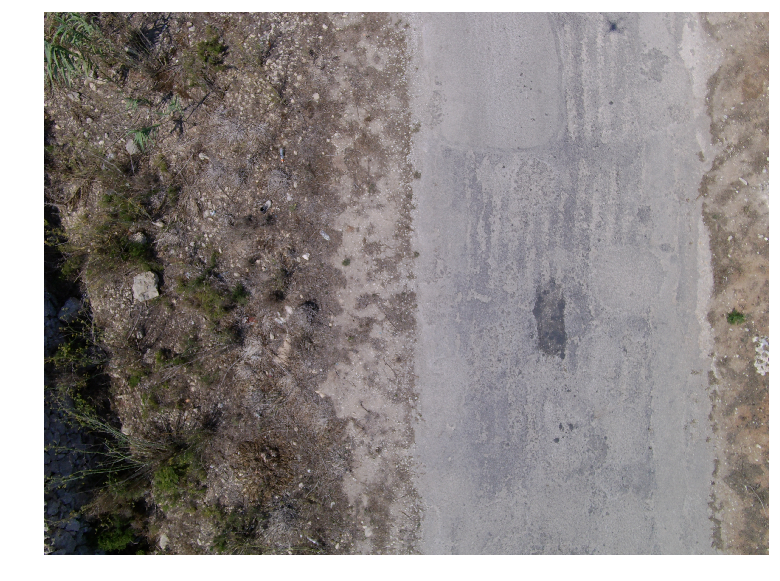

In [194]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

fullimage = cv2.imread(scenefile)
fullimage = cv2.cvtColor(fullimage, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(fullimage)
plt.show()

In [198]:
width, height, _ = fullimage.shape

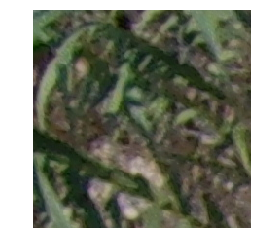

In [199]:
image_size=224
y=100
x=100

crop_image=fullimage[y:y+image_size,x:x+image_size]
crop_image = crop_image.astype("float") / 255.0
img = img_to_array(crop_image)
img = np.expand_dims(img, axis=0)

detectmap = model.predict(img)[0][1]

#image2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(crop_image)
plt.show()

In [200]:
img = np.array([np.transpose(np.float32(crop_image), (0, 1, 2))])
img.shape

(1, 224, 224, 3)

In [201]:
i=model.layers[0]

## Get Input Layer
j=i.layers[0]
inc=j.input
print(inc)

#Get last layer
j=i.layers[-2]
conv53=j.output
print(conv53)

getoutput=K.function([inc],[conv53])

Tensor("input_1_4:0", shape=(?, 224, 224, 3), dtype=float32)
Tensor("block5_conv3_4/Relu:0", shape=(?, 14, 14, 512), dtype=float32)


In [203]:
conv_outputs = getoutput([img])[0][0,:,:,:]
conv_outputs.shape

(14, 14, 512)

In [ ]:
#Get the 512 input weights to the softmax.
class_weights = model.layers[-1].get_weights()[0]

VGG_t=model.layers[0]
for i in VGG_t.layers:
    if i.name=="input_1":
        input_layer=i.get_input_at
    if i.name=="block5_conv3":
        final_conv_layer=i.get_output_at

get_output = K.function([input_layer], [final_conv_layer, model.layers[-1].output])
[conv_outputs, predictions] = get_output([img])
conv_outputs = conv_outputs[0, :, :, :]

In [204]:
x = image.img_to_array(crop_image)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [223]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, 1]


In [224]:
class_output

<tf.Tensor 'strided_slice_4:0' shape=(?,) dtype=float32>

In [225]:
grads = K.gradients(class_output, conv_outputs)
print(grads)

[None]


In [226]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

AttributeError: 'list' object has no attribute 'dtype'